# Weapon usage trends v2

Calculations of weapon usage are based on weapon_kills/all_kills ratio for each player and round [as suggested by Fri](https://discord.com/channels/498800300199772162/977172055361470474/1063083053003583548). With this approach weapons that are getting less kills but more caps (eg m79) are treated more fairly compared to those that are good at getting high kill count (eg mp5, rheinmetall).

In [1]:
import pandas as pd
import seaborn as sns
from IPython.core.display import Markdown
from pandas import DataFrame

from s2_analytics import sqlite_import


def dump_csv(df: DataFrame, id: str):
    csv_path = f"data/{id}.csv"
    csv_abs_path = f"{os.getcwd()}/build/markdown/{csv_path}"
    df.to_csv(csv_abs_path)
    display(Markdown(f"Chart data: [csv]({csv_path})"))

con, cur = sqlite_import.import_games("logs_ranked/", period_days=60)

cur.execute("""
    create table weapon_usage_by_date as
        select dw.date, weaponName, sum(wu.usage)/(select count(1) from round where round.date = dw.date) as usage
        from
        -- all date+weapon combinations
            (select *
            from (select distinct date from event_kill)
                     cross join (select distinct weaponName from event_kill) ) dw

        left outer join weapon_usage wu on wu.date = dw.date and wu.weapon = dw.weaponName
        group by dw.date, weaponName
        order by dw.date, sum(wu.usage) desc, weaponName
    """)
pass

## Data summary


In [2]:
query = """
    select
        datetime(min(id)/1000, 'unixepoch') first_game,
        datetime(max(id)/1000, 'unixepoch') last_game,
        count(1) games_count
    from game
"""
pd.read_sql_query(query, con)

,first_game,last_game,games_count
0,2022-11-19 19:34:00,2023-01-17 00:25:18,675


In [3]:
query = """
    select
        playlistCode,
        count(1) games_count
    from game group by playlistCode
"""
pd.read_sql_query(query, con)

,playlistCode,games_count
0,CTF-Standard-4,29
1,CTF-Standard-6,641
2,CTF-Standard-8,5


## Primary weapons

Chart data: [csv](data/wu2_ra_21_DeaglesMP5SteyrAUGKalashnikovSpas12M79DragunovBarrettRocketLauncherRheinmetallMinigun.csv)

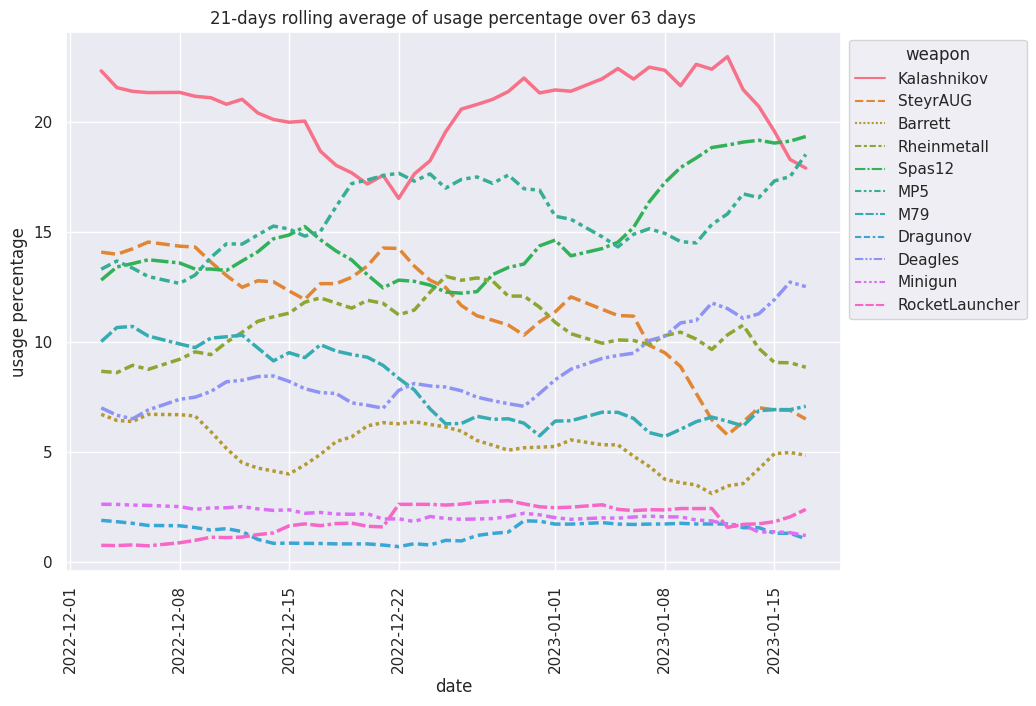

In [4]:
import os
from s2_analytics.constants import WEAPONS_SECONDARY, WEAPONS_PRIMARY
from matplotlib.ticker import FixedLocator
from IPython.display import display


def rolling_average_weapons_used(days: int, weapons_list, chart_height):
    total_period = days * 3
    weapons_list_str = ", ".join([f"'{x}'" for x in weapons_list])
    df = pd.read_sql_query(f"""
    select
        weaponName as weapon,
        date,
        usage,
        100.0 * usage /
            (select sum(usage)
                from weapon_usage_by_date wu2
                where wu.date = wu2.date and weaponName in ({weapons_list_str})
            ) as 'usage percentage'
    from weapon_usage_by_date wu
        where date >= datetime('now', '-{total_period} days')
        and weaponName in ({weapons_list_str})
    """, con, parse_dates=['date'])

    df["usage percentage"] = df.groupby("weapon", as_index=False, group_keys=False)\
        .apply(lambda grp, freq: grp.rolling(freq, on='date', min_periods=int(days * 0.75))['usage percentage'].mean(), f"{days}D")

    def generate_rolling_average_plot(df, days: int, chart_height):
        sns.set(rc={'figure.figsize': (10, chart_height)})
        plt = sns.lineplot(df, x="date", y=f"usage percentage", style="weapon",
                           hue="weapon", linewidth=2.5)
        plt.xaxis.set_major_locator(FixedLocator(plt.get_xticks().tolist()))
        plt.set_xticklabels(plt.get_xticklabels(), rotation=90)
        plt.set_title(f"{days}-days rolling average of usage percentage over {total_period} days")
        sns.move_legend(plt, "upper left", bbox_to_anchor=(1, 1))
        return plt

    generate_rolling_average_plot(df, days, chart_height=chart_height)
    dump_csv(df, f"wu2_ra_{days}_{''.join(weapons_list)}")


rolling_average_weapons_used(21, WEAPONS_PRIMARY, chart_height=7)
pass

Chart data: [csv](data/wu2_ra_7_DeaglesMP5SteyrAUGKalashnikovSpas12M79DragunovBarrettRocketLauncherRheinmetallMinigun.csv)

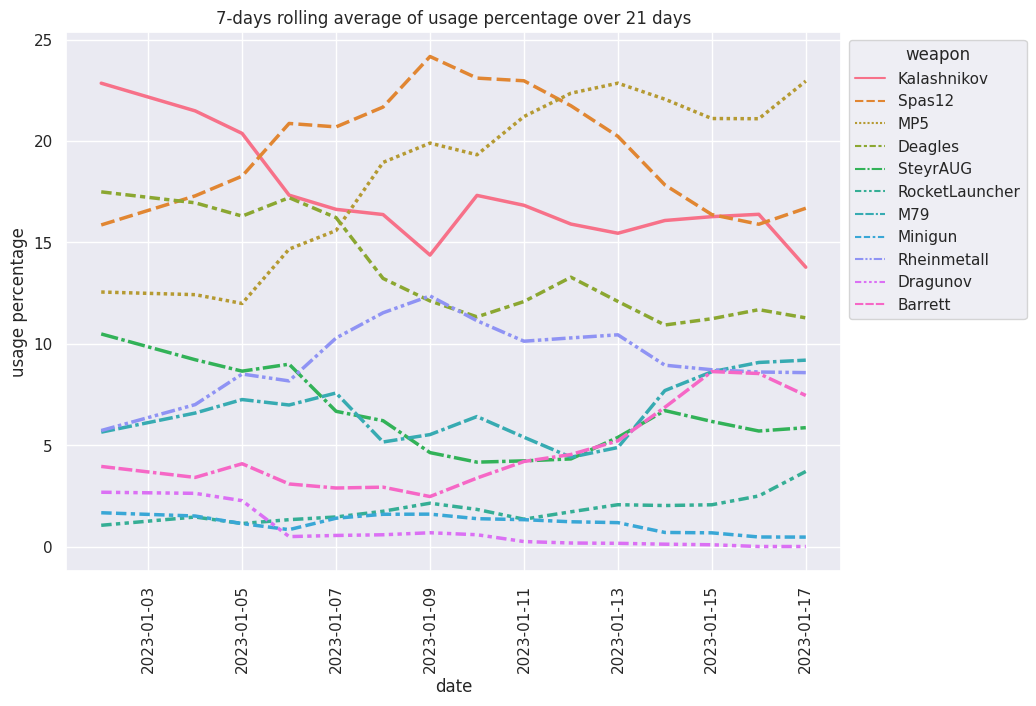

In [5]:
rolling_average_weapons_used(7, WEAPONS_PRIMARY, chart_height=7)
pass

## Secondary weapons


Chart data: [csv](data/wu2_ra_21_ChainsawKnifeMakarovRPG.csv)

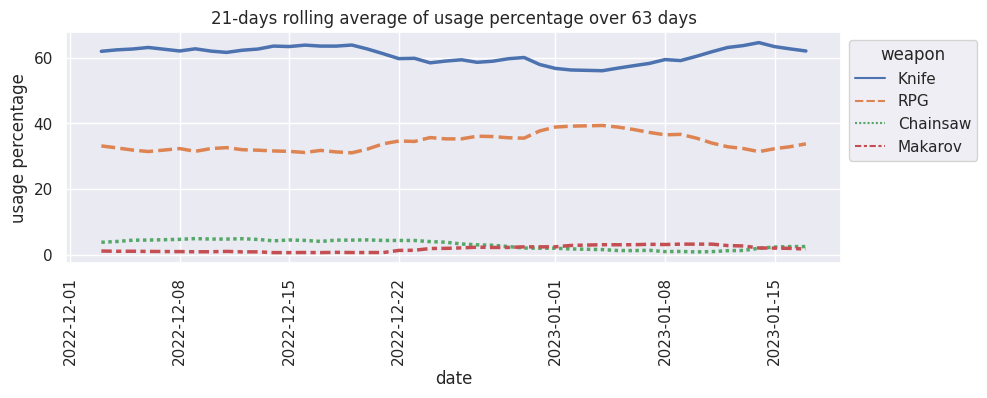

In [6]:
rolling_average_weapons_used(21, WEAPONS_SECONDARY, chart_height=3)
pass

Chart data: [csv](data/wu2_ra_7_ChainsawKnifeMakarovRPG.csv)

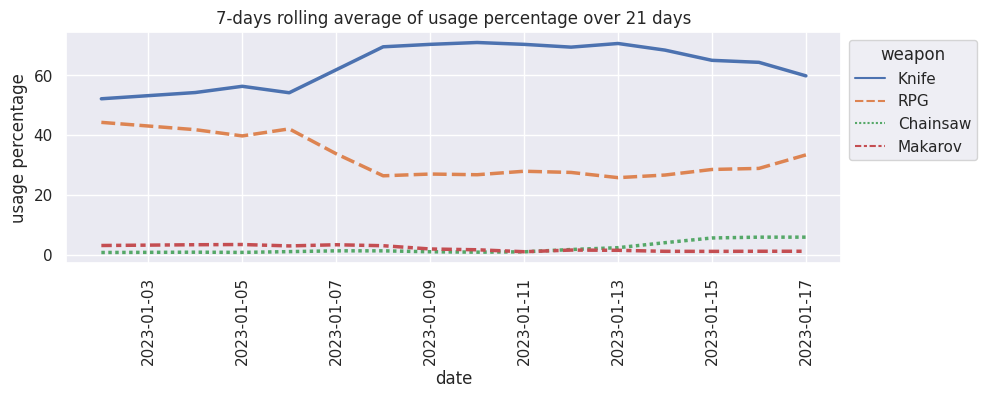

In [7]:
used = rolling_average_weapons_used(7, WEAPONS_SECONDARY, chart_height=3)
pass